<a href="https://colab.research.google.com/github/rahmanabidchy/Object-detection/blob/master/Object_detection_tf2_model_zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U --pre tensorflow=="2.2.0"

  Using cached https://files.pythonhosted.org/packages/3d/be/679ce5254a8c8d07470efb4a4c00345fae91f766e64f1c2aece8796d7218/tensorflow-2.2.0-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a4/f5/926ae53d6a226ec0fda5208e0e581cffed895ccc89e36ba76a8e60895b78/tensorflow_estimator-2.2.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/1d/74/0a6fcb206dcc72a6da9a62dd81784bfdbff5fedb099982861dc2219014fb/tensorboard-2.2.2-py3-none-any.whl
ERROR: tf-models-official 2.3.0 has requirement tensorflow>=2.3.0, but you'll have tensorflow 2.2.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.1
    Uninstalling tensorflow-2.3.

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Using cached https://files.pythonhosted.org/packages/ad/ad/769c195c72ac72040635c66cd9ba7b0f4b4fc1ac67e59b99fa6988446c22/tensorflow-2.3.1-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e9/1b/6a420d7e6ba431cf3d51b2a5bfa06a958c4141e3189385963dc7f6fbffb6/tensorboard-2.3.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e9/ed/5853ec0ae380cba4588eab1524e18ece1583b65f7ae0e97321f5ff9dfd60/tensorflow_estimator-2.3.0-py2.py3-none-any.whl
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1579568 sha256=72f2dfcab7f17b0942040d46053c2a9ba44501511180305b01f1b3c8fc5563c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-syyro1t2/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-

In [ ]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

In [ ]:
# Download the saved model and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d5_coco17_tpu-32.tar.gz
!mv efficientdet_d5_coco17_tpu-32/ models/research/object_detection/test_data/

--2020-10-08 10:03:15--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.31.128, 2607:f8b0:400c:c02::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.31.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256286417 (244M) [application/x-tar]
Saving to: ‘efficientdet_d5_coco17_tpu-32.tar.gz’

efficientdet_d5_coc 100%[===================>] 244.41M   123MB/s    in 2.0s    

2020-10-08 10:03:17 (123 MB/s) - ‘efficientdet_d5_coco17_tpu-32.tar.gz’ saved [256286417/256286417]



In [ ]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('models/research/object_detection/test_data/efficientdet_d5_coco17_tpu-32/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 58.76374626159668s


Elapsed time: 18.99995744228363 second per image


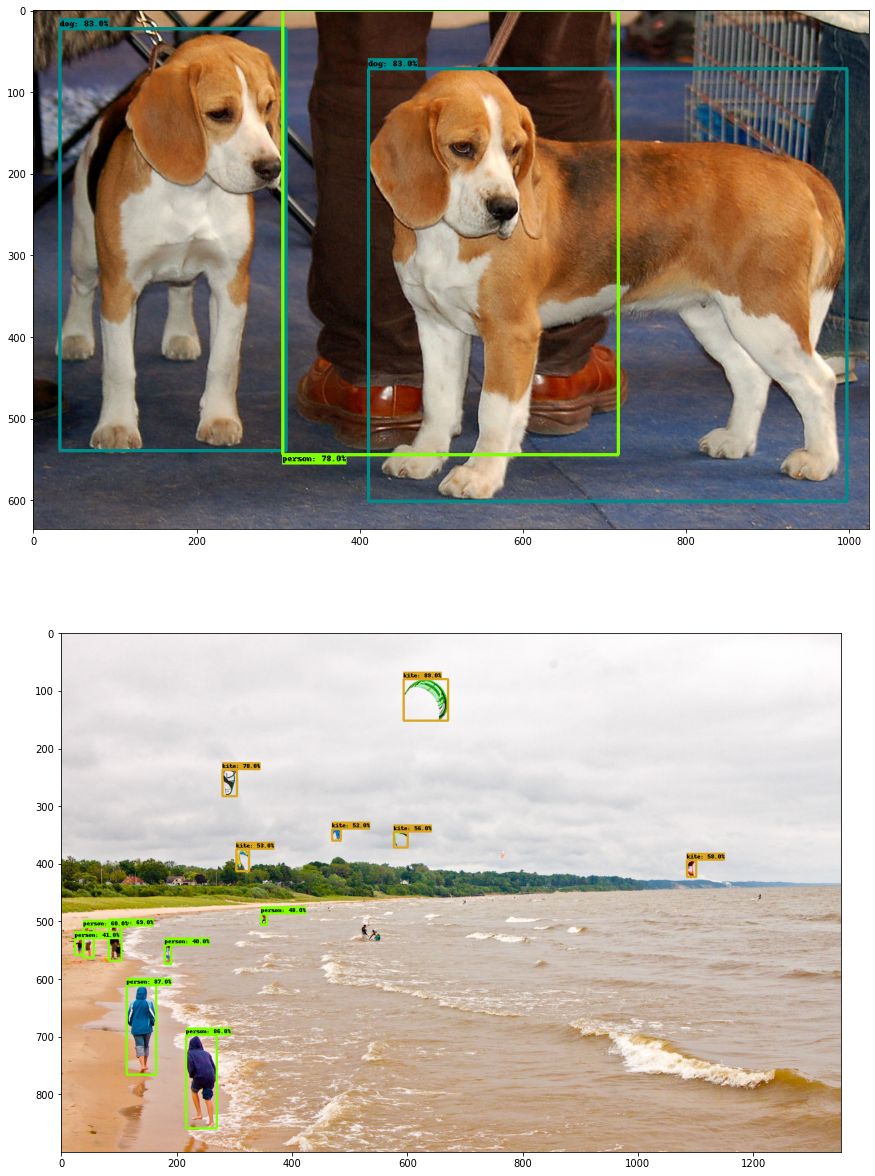

In [ ]:
import time

image_dir = 'models/research/object_detection/test_images'

elapsed = []
for i in range(2):
  image_path = os.path.join(image_dir, 'image' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
  plt.subplot(2, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')